In [1]:
#################################################################################
# This tuitoral performs basic data processing and data analysis for dataset using seurat
# refer to https://satijalab.org/seurat/ Vignette "Guided tutorial"
# Please modify this script to apply for specific dataset.
# Usage: Rscript HCA-d_data_processing_seurat.r datasetName dataFormat
# Usage example: Rscript HCA-d_data_processing_seurat.r spleen_spleen_Madissoon2019 10X
#################################################################################

# args = argsCommand(true)
# datasetName = args[1]
# #datasetName value: organ_tissue_authorYear without space
# dataFormat = args[2]
# #dataFormat value: tsv (tab separated), 10X (sparse)

datasetName = 'Blood_Blood_HCLAdult-Peripheral-Blood1'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/home/bianhaiyang/hcad/hcl/hcl_all/Blood_Blood_HCLAdult-Peripheral-Blood1")
library(Seurat)
library(data.table)
library(ggplot2)
#library(flexclust)
#install.packages('flexclust')

# setwd("/path/to/dataset/")
# library(Seurat)
# library(data.table)
# library(ggplot2)
# library(flexclust)
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation_hcad.tsv"), h = T, sep = "\t", row.names = 1)
}
# Extract demo data for test
#data.matrix <- data.matrix[,1:500]
#data.metadata <- data.metadata[1:500,]
#data.annotation <- data.annotation[1:500,,drop=FALSE]

# Pre-processing
min.cells = 3
min.features = 0
nFeature_RNA_range = c(20, 2000)
percent.mt.thre = 10

# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

# 2. run sctransform 
#dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj) 
dev.off()

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"Centering and scaling data matrix
PC_ 1 
Positive:  CCL5, NKG7, IL7R, CST7, GZMA, TRBC1, GZMH, TRBC2, CD7, GNLY 
	   PRF1, CD247, KLRB1, GZMB, KLRD1, FGFBP2, CCL4, CD8A, RPS27, TRGC2 
	   CCR7, CTSW, HOPX, RPL3, SPON2, TRDC, CD8B, TCF7, AC092580.4, RPS29 
Negative:  FTL, FCN1, PSAP, CST3, S100A8, LYZ, FTH1, TYROBP, S100A11, CTSS 
	   MNDA, CSTA, CD14, AIF1, FOS, SERPINA1, GRN, CD74, LST1, FOLR3 
	   CLEC12A, TYMP, NCF2, FPR1, OAZ1, FGL2, MS4A6A, TMSB10, SPI1, RGS2 
PC_ 2 
Positive:  NKG7, GNLY, MYOM2, GZMA, FGFBP2, CCL5, PRF1, CST7, GZMB, SPON2 
	   KLRD1, CTSW, CCL4, GZMH, KLRF1, FCGR3A, CX3CR1, TRDC, KLRB1, TYROBP 
	   CLIC3, SRGN, KIR2DS4, SH2D1B, LAIR2, S100A8, IL2RB, IGFBP7, ADGRG1, S1PR5 
Negative:  RPS29, RPS27, RPL13, RPL34, RPL32, RPL30, RPLP2, RPLP1, RPS6, RPL13A 
	   RPS12, RPS18, RPL10, RPL21, RPL19, RPS27A, RPS14, RPL11, RPS3A, RPL31 
	   RPL9, RPL37, RPS16, RPS25, RPL39, EEF1A1, RPL

png 
  2

In [2]:
data.annotation2

,cell_ontology_class
,<fct>
CordBlood_1.AAAACGAACGCCAGGACT,Blood-Blood-Hemopoietic stem cell-Multipotent progenitor/MPP-Common myeloid progenitor/CMP or common granulocyte/megakaryocyte/erythrocyte progenitor/CFU-GEMM-Granulocyte macrophage progenitor/GMP-(Leukopoiesis)-MonocyteCD14
CordBlood_1.AAAACGAGGGTCGTCCCG,Blood-Blood-Hemopoietic stem cell-Multipotent progenitor/MPP-Common myeloid progenitor/CMP or common granulocyte/megakaryocyte/erythrocyte progenitor/CFU-GEMM-Macrophage dendritic cell progenitor-Common dendritic cell precursor-Pre conventional dendritic cell-Conventional dendritic cellFCER1A CD1C CST3
CordBlood_1.AAAACGATGGCGAGATGG,Blood-Blood-Hemopoietic stem cell-Multipotent progenitor/MPP-Common myeloid progenitor/CMP or common granulocyte/megakaryocyte/erythrocyte progenitor/CFU-GEMM-Megakaryocyte erythrocyte progenitor/MEP-(Erythropoiesis)-Proerythroblast-Basophilic erythroblast-Polychromatophilic erythroblast-Orthochromatophilic erythroblast/normoblast-Reticulocyte-ErythrocyteCD233
CordBlood_1.AAAACGCAAAGTCCATCT,Blood-Blood-Hemopoietic stem cell-Multipotent progenitor/MPP-Common myeloid progenitor/CMP or common granulocyte/megakaryocyte/erythrocyte progenitor/CFU-GEMM-Megakaryocyte erythrocyte progenitor/MEP-(Erythropoiesis)-Proerythroblast-Basophilic erythroblast-Polychromatophilic erythroblast-Orthochromatophilic erythroblast/normoblast-Reticulocyte-ErythrocyteCD233
CordBlood_1.AAAACGCTCGCAGTCGGT,Blood-Blood-Hemopoietic stem cell-Multipotent progenitor/MPP-Common myeloid progenitor/CMP or common granulocyte/megakaryocyte/erythrocyte progenitor/CFU-GEMM-Granulocyte macrophage progenitor/GMP-(Leukopoiesis)-Myeloblast-Promyelocyte-Neutrophilic myelocyte-Neutrophilic metamyelocyte-NeutrophilCD66b
CordBlood_1.AAAACGGCAGGACGCTTG,Blood-Blood-Hemopoietic stem cell-Multipotent progenitor/MPP-Common myeloid progenitor/CMP or common granulocyte/megakaryocyte/erythrocyte progenitor/CFU-GEMM-Granulocyte macrophage progenitor/GMP-(Leukopoiesis)-Myeloblast-Promyelocyte-Neutrophilic myelocyte-Neutrophilic metamyelocyte-NeutrophilCD66b
CordBlood_1.AAAACGGCAGGAGGACAT,Blood-Blood-Hemopoietic stem cell-Multipotent progenitor/MPP-Common myeloid progenitor/CMP or common granulocyte/megakaryocyte/erythrocyte progenitor/CFU-GEMM-Granulocyte macrophage progenitor/GMP-(Leukopoiesis)-MonocyteCD14
CordBlood_1.AAAACGGCGTCCACGTTG,Blood-Blood-Hemopoietic stem cell-Multipotent progenitor/MPP-Common lymphoid progenitor/CLP-(B cell line)-B cell (Centrocyte)-CD79A CD79B
CordBlood_1.AAAACGGGGTTTTGCGGA,Blood-Blood-Hemopoietic stem cell-Multipotent progenitor/MPP-Common myeloid progenitor/CMP or common granulocyte/megakaryocyte/erythrocyte progenitor/CFU-GEMM-Granulocyte macrophage progenitor/GMP-(Leukopoiesis)-MonocyteCD14


In [2]:
pcDim = 30 # set as 75 in this case 
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 1, n.start = 10)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2719
Number of edges: 166913

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7752
Number of communities: 10
Elapsed time: 0 seconds


In [3]:
# Visulize the clustering result
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"16:06:42 UMAP embedding parameters a = 0.9922 b = 1.112
16:06:42 Read 2719 rows and found 30 numeric columns
16:06:42 Using Annoy for neighbor search, n_neighbors = 30
16:06:42 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
16:06:43 Writing NN index file to temp file /tmp/RtmpqS2XOL/file5ab761963452
16:06:43 Searching Annoy index using 1 thread, search_k = 3000
16:06:44 Annoy recall = 100%
16:06:44 Commencing smooth kNN distance calibration using 1 thread
16:06:44 Initializing from normalized Laplacian + noise
16:06:44 Commencing optimizatio

In [7]:
new.cluster.ids<-c('Blood-Connective Tissue-Monocyte-CD14 FCN1','Blood-Connective Tissue-T cell-CD3D','Blood-Connective Tissue-T cell-CD3D','Blood-Connective Tissue-T cell-CD3D','Blood-Connective Tissue-NK cell-NKG7','Blood-Connective Tissue-Plasma B Cell-CD79A','Blood-Connective Tissue-Macrophage-FCER1G FCGR3A','Blood-Connective Tissue-Conventional dendritic cell-CD74 CD1C','Blood-Connective Tissue-Plasmacytoid dendritic cell-IRF8','Blood-Connective Tissue-Plasma B Cell-JCHAIN')

In [8]:
names(new.cluster.ids) <- levels(dataobj)
dataobj.renamed <- RenameIdents(dataobj, new.cluster.ids)

In [9]:
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [18]:
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)
hcad.label = Idents(dataobj)
dataobj <- AddMetaData(dataobj, metadata = hcad.label,col.name = 'hcad.label')

Warning message:
"Cannot find identity NA"Warning message:
"Cannot find identity NA"

In [11]:
dataobj$celltype = Idents(dataobj)

In [19]:
dataobj[[]]

,orig.ident,nCount_RNA,nFeature_RNA,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age,cell_cluster,percent.mt,RNA_snn_res.1,seurat_clusters,celltype,hcad.label
,<fct>,<dbl>,<int>,<fct>,<fct>,<lgl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>
PeripheralBlood_1.AAAACGAACCTAACTTAT,PeripheralBlood,931,645,Periphera Blood,Periphera Blood,NA,normal,AdultPeripheralBlood1_34Y,Male,34Y,NK cell,2.7926960,9,9,Blood-Connective Tissue-Plasma B Cell-JCHAIN,Blood-Connective Tissue-Conventional dendritic cell-CD74 CD1C
PeripheralBlood_1.AAAACGACGAGCTGAAGC,PeripheralBlood,370,322,Periphera Blood,Periphera Blood,NA,normal,AdultPeripheralBlood1_34Y,Male,34Y,CD8_T cell,2.7027027,1,1,Blood-Connective Tissue-T cell-CD3D,Blood-Connective Tissue-T cell-CD3D
PeripheralBlood_1.AAAACGACGTTGGAACGC,PeripheralBlood,910,606,Periphera Blood,Periphera Blood,NA,normal,AdultPeripheralBlood1_34Y,Male,34Y,Macrophage,2.5274725,6,6,Blood-Connective Tissue-Macrophage-FCER1G FCGR3A,Blood-Connective Tissue-NK cell-NKG7
PeripheralBlood_1.AAAACGAGGGTCACAATA,PeripheralBlood,536,417,Periphera Blood,Periphera Blood,NA,normal,AdultPeripheralBlood1_34Y,Male,34Y,NK cell,1.6791045,4,4,Blood-Connective Tissue-NK cell-NKG7,Blood-Connective Tissue-T cell-CD3D
PeripheralBlood_1.AAAACGAGTTTAGTTGCC,PeripheralBlood,605,448,Periphera Blood,Periphera Blood,NA,normal,AdultPeripheralBlood1_34Y,Male,34Y,CD4_T cell,3.6363636,3,3,Blood-Connective Tissue-T cell-CD3D,Blood-Connective Tissue-T cell-CD3D
PeripheralBlood_1.AAAACGATTCCACGGCAG,PeripheralBlood,488,392,Periphera Blood,Periphera Blood,NA,normal,AdultPeripheralBlood1_34Y,Male,34Y,CD4_T cell,2.0491803,2,2,Blood-Connective Tissue-T cell-CD3D,Blood-Connective Tissue-T cell-CD3D
PeripheralBlood_1.AAAACGATTCCATAGAGA,PeripheralBlood,1230,762,Periphera Blood,Periphera Blood,NA,normal,AdultPeripheralBlood1_34Y,Male,34Y,Macrophage,3.3333333,6,6,Blood-Connective Tissue-Macrophage-FCER1G FCGR3A,Blood-Connective Tissue-NK cell-NKG7
PeripheralBlood_1.AAAACGCACAAGGCCTAG,PeripheralBlood,399,319,Periphera Blood,Periphera Blood,NA,normal,AdultPeripheralBlood1_34Y,Male,34Y,CD4_T cell,2.5062657,1,1,Blood-Connective Tissue-T cell-CD3D,Blood-Connective Tissue-T cell-CD3D
PeripheralBlood_1.AAAACGCCTTTCGAACGC,PeripheralBlood,341,283,Periphera Blood,Periphera Blood,NA,normal,AdultPeripheralBlood1_34Y,Male,34Y,CD4_T cell,3.5190616,1,1,Blood-Connective Tissue-T cell-CD3D,Blood-Connective Tissue-T cell-CD3D


Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."

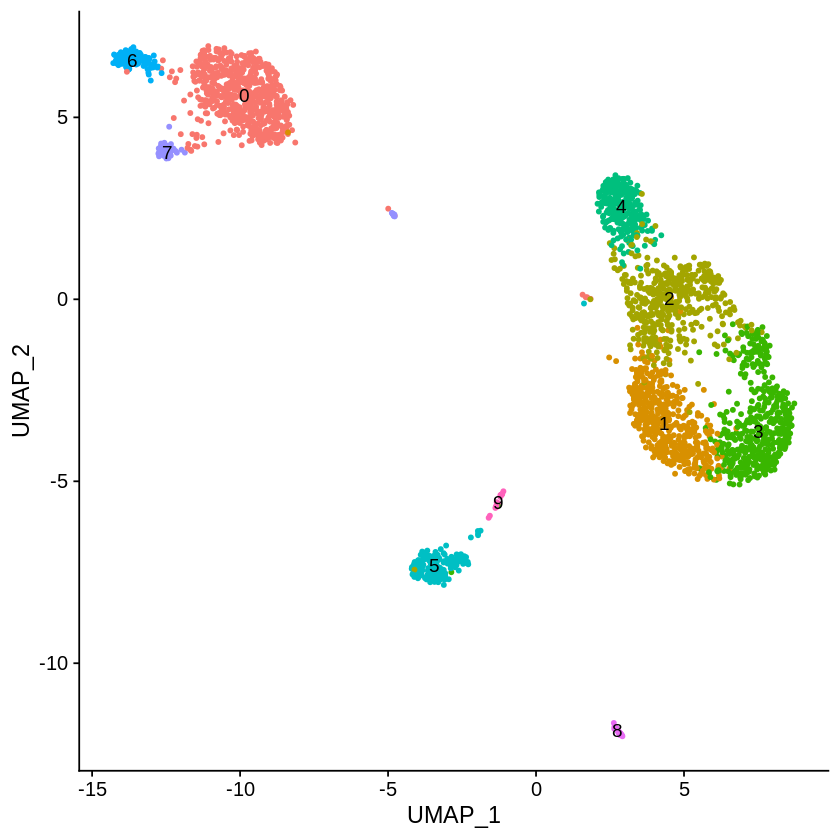

In [4]:
DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)+NoLegend()

In [13]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap, width = 8, height = 5)

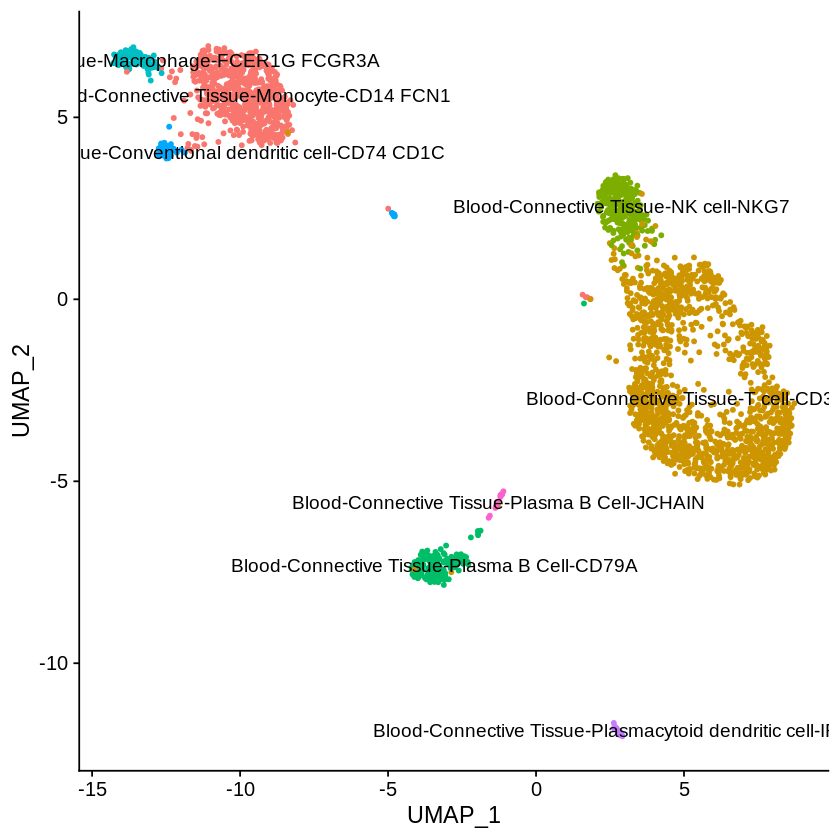

In [14]:
p_umap

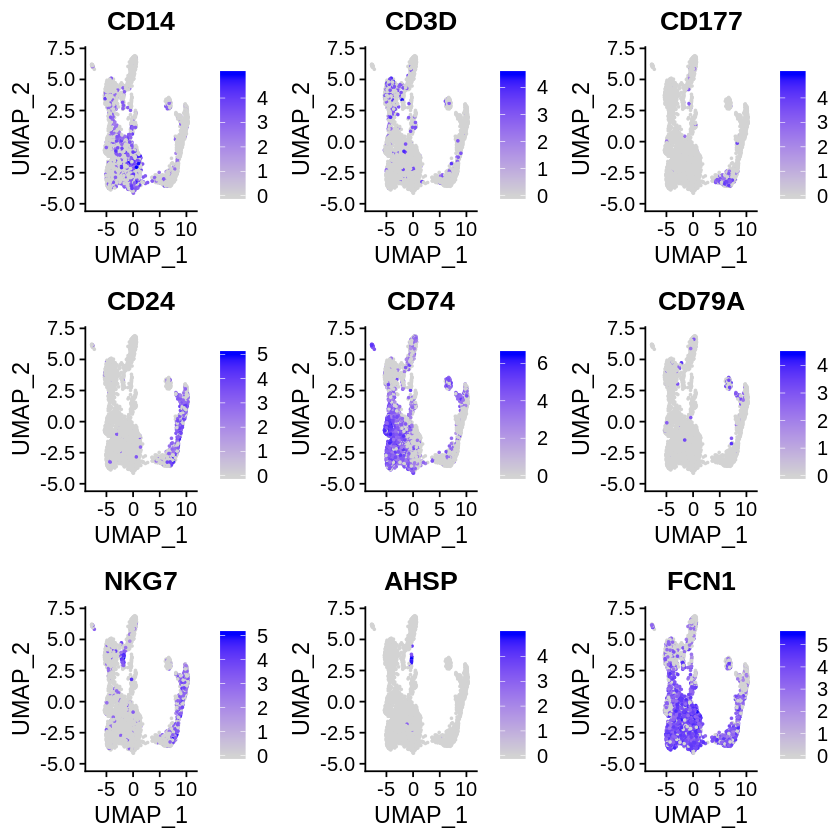

In [20]:
FeaturePlot(dataobj,features = c('CD14','CD3D','CD177','CD24','CD74','CD79A','NKG7','AHSP','FCN1'))

In [25]:
dataobj

An object of class Seurat 
13539 features across 4432 samples within 1 assay 
Active assay: RNA (13539 features)
 2 dimensional reductions calculated: pca, umap

In [14]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cluster.ids", pt.size=1)

ERROR: Error in `[[.Seurat`(object, group.by): Cannot find 'cluster.ids' in this Seurat object


In [15]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height =5)

ERROR: Error in `[[.Seurat`(object, group.by): Cannot find 'cell_cluster' in this Seurat object


In [8]:
dataobj[['RNA']]@counts[1:5,1:5]

ERROR: Error in eval(expr, envir, enclos): object 'dataobj' not found


In [ ]:
VlnPlot(dataobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)#+scale_color_npg() 不起作用

In [ ]:
ElbowPlot(dataobj)

In [15]:
# Compare the seurat clusters with original clusters
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

ERROR: Error in randIndex(dataobj$cell_cluster, dataobj$seurat_clusters): could not find function "randIndex"


In [15]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height =5)
if (file.exists(paste0(datasetName,"_annotation_hcad.tsv"))) {
    p_umap3 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_ontology_class", pt.size=1)+NoLegend()
    ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap3, width = 8, height = 5)
}

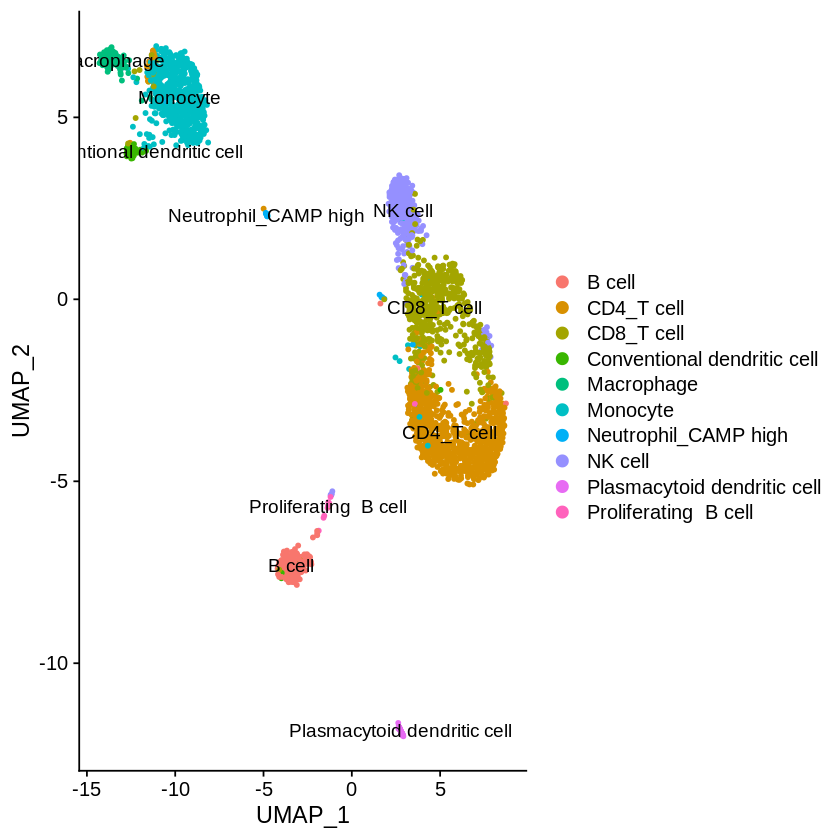

In [16]:
p_umap2

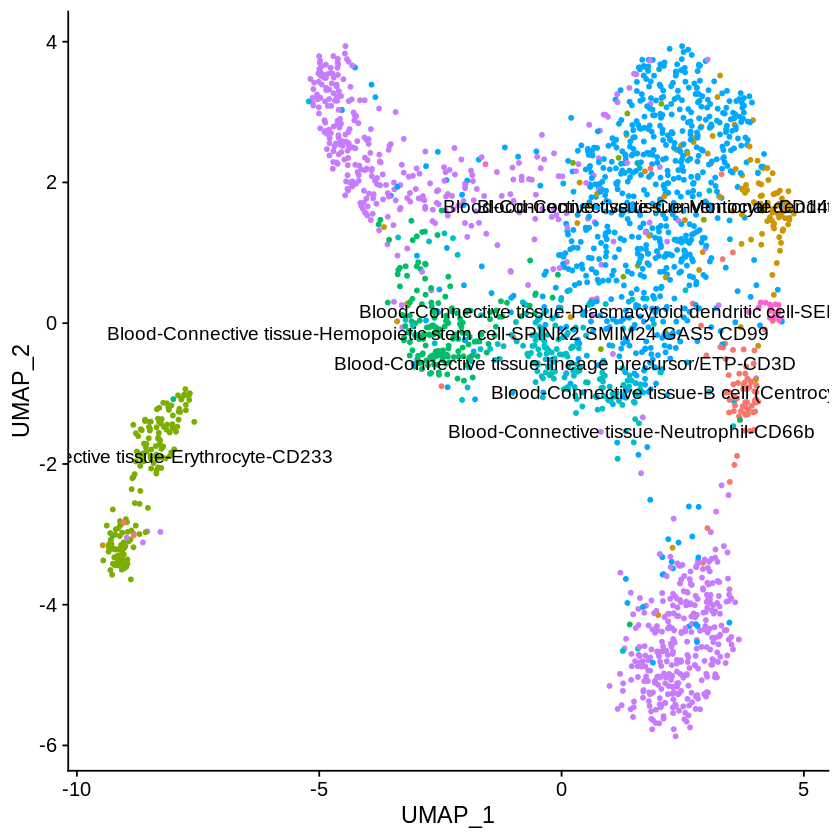

In [7]:
p_umap3

In [46]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster Blood-Connective Tissue-Monocyte-CD14
Calculating cluster Blood-Connective Tissue-T cell-CD3D
Calculating cluster Blood-Connective Tissue-Neutrophil-CD177
Calculating cluster Blood-Connective Tissue-Hemopoietic stem cell-CD99
Calculating cluster Blood-Connective Tissue-Neutrophil-CD24
Calculating cluster Blood-Connective Tissue-Monocyte-FCN1
Calculating cluster Blood-Connective Tissue-Plasma B Cell-CD79A
Calculating cluster Blood-Connective Tissue-Conventional dendritic cell-CD74
Calculating cluster Blood-Connective Tissue-Megakaryocyte-GP9
Calculating cluster Blood-Connective Tissue-NK cell-NKG7
Calculating cluster Blood-Connective Tissue-Plasma B Cell-JCHAIN
Calculating cluster Blood-Connective Tissue-Erythrocyte-AHSP


In [45]:
write.table(Idents(dataobj), file = paste0(datasetName,".seurat.annotation_hcad.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

In [20]:
saveRDS(dataobj, file = paste0(datasetName,"copy.seuratobj.rds"))